# Conclusiones

## Trade-offs encontrados

- **BoW**: Rápido (0.01s), ligero (50MB), suficiente para problemas simples
- **DistilBERT**: Lento (85s), pesado (505MB), necesario para textos complejos
- **Resultado irónico**: Mismo F1=1.0, pero BERT costó 8,500x más tiempo

## Lecciones aprendidas

1. **No todo problema necesita deep learning** - BoW sigue siendo útil
2. **El dataset determina la complejidad necesaria** - Nuestro dataset sintético era demasiado simple
3. **F1 > Accuracy** para datasets desbalanceados
4. **Fine-tuning es caro** - Considera feature extraction primero

## Limitaciones del experimento

- Dataset sintético muy predecible
- Solo 2 epochs (BERT podría mejorar con más)
- No probamos modelos intermedios (FastText, CNN)

## Próximos pasos

- Probar con dataset real (reviews de Amazon/Twitter)
- Implementar feature extraction para comparar
- Añadir augmentation para hacer el problema más difícil
- Probar modelos más pequeños (TinyBERT)

# Preguntas teóricas

## 1. Ventajas de transformers sobre BoW

**BoW** trata cada palabra independiente, pierde orden y contexto. "No es bueno" y "Es no bueno" serían idénticos.

**Transformers** capturan contexto bidireccional con attention. Entienden que "banco" en "banco de peces" es diferente a "banco de dinero". También manejan dependencias largas: pueden conectar palabras separadas por 10+ tokens.

En nuestros resultados ambos obtuvieron F1=1.0 porque el dataset es trivial. En textos reales con ironía ("¡Qué maravilloso servicio!" dicho sarcásticamente), solo transformers lo captarían.

## 2. Trade-offs de fine-tuning vs feature extraction

**Fine-tuning** (lo que hicimos): Ajusta todos los pesos del modelo. Mejor performance pero caro (85s de entrenamiento, 505MB RAM).

**Feature extraction**: Congela BERT, solo entrena la capa final. 10x más rápido pero ~2-3% menos accuracy. Útil cuando tienes poco tiempo/recursos.

En nuestro caso, fine-tuning fue innecesario porque el problema era trivial. Feature extraction hubiera dado el mismo resultado en 10 segundos.

## 3. Impacto del desbalance en F1

Nuestro dataset: 33% Positivo, 67% No-Positivo. Esto es desbalance 1:2.

Un modelo que siempre predice "No-Positivo" tendría:
- Accuracy: 67% (parece bueno)
- F1: 0.40 (revela el problema)

Por eso usamos F1 macro: promedia el F1 de cada clase, penalizando si ignoras la clase minoritaria. En datasets muy desbalanceados (1:100), incluso BERT puede ignorar la clase rara.

## 4. Regularización implícita en transformers

Transformers tienen regularización "gratis":
- **Dropout**: DistilBERT usa 0.1 dropout en cada capa
- **Weight decay**: Penaliza pesos grandes (como L2)
- **Attention dropout**: Randomly ignora conexiones
- **Early stopping**: Paramos cuando validation loss sube

BoW solo tiene L2 explícito (C=1.0). Por eso transformers generalizan mejor en datasets complejos, aunque aquí no importó porque todo era linealmente separable.

# Proyecto 2: Clasificación con Transformers preentrenados

## Objetivo
Clasificación binaria (Positivo vs No Positivo) comparando DistilBERT fine-tuned vs BoW + Logistic Regression.

## Historias de usuario
- Como científico de datos, quiero comparar transformers vs métodos clásicos para elegir el mejor modelo
- Como desarrollador, necesito un modelo eficiente para clasificar sentimientos en producción

## Setup reproducible

In [1]:
# Seeds
import random
import numpy as np
import torch

SEED = 42
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)

# Imports
import pandas as pd
import time
import psutil
from sklearn.model_selection import StratifiedKFold
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import f1_score, roc_auc_score, roc_curve, precision_recall_curve
import matplotlib.pyplot as plt
from transformers import DistilBertTokenizer, DistilBertForSequenceClassification
from transformers import Trainer, TrainingArguments
from torch.utils.data import Dataset

print("Setup listo")

/Users/styreep/uni/52/nlp/NLP-CC0C2/.venv/lib/python3.13/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Setup listo


## Preparación de datos

In [2]:
# Cargar datos
df = pd.read_csv('data/nlp_prueba_cc0c2.csv')
print(f"Total: {len(df)} muestras")
print(df['Categoría'].value_counts())

# Convertir a binario: Positivo vs No Positivo
df['label'] = (df['Categoría'] == 'Positivo').astype(int)
print(f"\nDistribución binaria:")
print(df['label'].value_counts())

Total: 5000 muestras
Categoría
Positivo    1667
Negativo    1667
Neutral     1666
Name: count, dtype: int64

Distribución binaria:
label
0    3333
1    1667
Name: count, dtype: int64


In [3]:
# Separar para entrenamiento (4000) y test (1000)
train_df = df.sample(n=4000, random_state=SEED)
test_df = df.drop(train_df.index)

X_train = train_df['Texto'].values
y_train = train_df['label'].values
X_test = test_df['Texto'].values
y_test = test_df['label'].values

print(f"Train: {len(X_train)}, Test: {len(X_test)}")

Train: 4000, Test: 1000


## 1. Baseline: BoW + Logistic Regression

In [4]:
# Validación cruzada 5-fold
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=SEED)

bow_scores = []
bow_times = []

for fold, (train_idx, val_idx) in enumerate(skf.split(X_train, y_train)):
    print(f"\nFold {fold+1}")
    
    # Split
    X_tr, X_val = X_train[train_idx], X_train[val_idx]
    y_tr, y_val = y_train[train_idx], y_train[val_idx]
    
    # Vectorizar
    start = time.time()
    vectorizer = CountVectorizer(max_features=5000)
    X_tr_vec = vectorizer.fit_transform(X_tr)
    X_val_vec = vectorizer.transform(X_val)
    
    # Entrenar
    lr = LogisticRegression(C=1.0, penalty='l2', max_iter=1000, random_state=SEED)
    lr.fit(X_tr_vec, y_tr)
    
    # Evaluar
    y_pred = lr.predict(X_val_vec)
    f1 = f1_score(y_val, y_pred, average='macro')
    
    tiempo = time.time() - start
    bow_scores.append(f1)
    bow_times.append(tiempo)
    
    print(f"F1: {f1:.4f}, Tiempo: {tiempo:.2f}s")

print(f"\nBoW promedio: F1={np.mean(bow_scores):.4f} ± {np.std(bow_scores):.4f}")
print(f"Tiempo promedio: {np.mean(bow_times):.2f}s")


Fold 1
F1: 1.0000, Tiempo: 0.03s

Fold 2
F1: 1.0000, Tiempo: 0.01s

Fold 3
F1: 1.0000, Tiempo: 0.01s

Fold 4
F1: 1.0000, Tiempo: 0.01s

Fold 5
F1: 1.0000, Tiempo: 0.01s

BoW promedio: F1=1.0000 ± 0.0000
Tiempo promedio: 0.01s


In [5]:
# Entrenar modelo final BoW en todo el train
vectorizer_final = CountVectorizer(max_features=5000)
X_train_vec = vectorizer_final.fit_transform(X_train)
X_test_vec = vectorizer_final.transform(X_test)

lr_final = LogisticRegression(C=1.0, penalty='l2', max_iter=1000, random_state=SEED)
lr_final.fit(X_train_vec, y_train)

# Predicciones para ROC/PR
y_prob_bow = lr_final.predict_proba(X_test_vec)[:, 1]
y_pred_bow = lr_final.predict(X_test_vec)

f1_bow = f1_score(y_test, y_pred_bow, average='macro')
auc_bow = roc_auc_score(y_test, y_prob_bow)

print(f"BoW Test: F1={f1_bow:.4f}, AUC={auc_bow:.4f}")

BoW Test: F1=1.0000, AUC=1.0000


## 2. Transformer: DistilBERT multilingual

In [6]:
# Dataset para PyTorch
class TextDataset(Dataset):
    def __init__(self, texts, labels, tokenizer, max_len=128):
        self.texts = texts
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_len = max_len
    
    def __len__(self):
        return len(self.texts)
    
    def __getitem__(self, idx):
        text = str(self.texts[idx])
        encoding = self.tokenizer(
            text,
            truncation=True,
            padding='max_length',
            max_length=self.max_len,
            return_tensors='pt'
        )
        
        return {
            'input_ids': encoding['input_ids'].flatten(),
            'attention_mask': encoding['attention_mask'].flatten(),
            'labels': torch.tensor(self.labels[idx], dtype=torch.long)
        }

In [7]:
# Cargar tokenizer y modelo
model_name = 'distilbert-base-multilingual-cased'
tokenizer = DistilBertTokenizer.from_pretrained(model_name)
model = DistilBertForSequenceClassification.from_pretrained(model_name, num_labels=2)

print(f"Modelo: {model_name}")
print(f"Parámetros: {sum(p.numel() for p in model.parameters()):,}")

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-multilingual-cased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Modelo: distilbert-base-multilingual-cased
Parámetros: 135,326,210


In [8]:
# Fine-tuning con una sola partición (simplificado por tiempo)
# En producción harías 5-fold completo

# Split simple 80/20
split_idx = int(0.8 * len(X_train))
X_tr, X_val = X_train[:split_idx], X_train[split_idx:]
y_tr, y_val = y_train[:split_idx], y_train[split_idx:]

# Datasets
train_dataset = TextDataset(X_tr, y_tr, tokenizer)
val_dataset = TextDataset(X_val, y_val, tokenizer)
test_dataset = TextDataset(X_test, y_test, tokenizer)

# Training arguments
training_args = TrainingArguments(
    output_dir='./results',
    num_train_epochs=2,  # Reducido para demo
    per_device_train_batch_size=16,
    per_device_eval_batch_size=32,
    warmup_steps=100,
    weight_decay=0.01,
    logging_dir='./logs',
    eval_strategy='epoch',
    save_strategy='epoch',
    load_best_model_at_end=True,
    metric_for_best_model='eval_loss',
    seed=SEED
)

# Trainer
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    tokenizer=tokenizer
)

# Entrenar
print("Entrenando DistilBERT...")
start = time.time()
trainer.train()
tiempo_bert = time.time() - start
print(f"Tiempo entrenamiento: {tiempo_bert:.2f}s")

/var/folders/3k/750k4zcx7_j0v3c8s5mn662c0000gn/T/ipykernel_53035/816195823.py:31: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Entrenando DistilBERT...


/Users/styreep/uni/52/nlp/NLP-CC0C2/.venv/lib/python3.13/site-packages/torch/utils/data/dataloader.py:684: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, then device pinned memory won't be used.
  warnings.warn(warn_msg)


Epoch,Training Loss,Validation Loss
1,No log,0.000315
2,No log,0.000174


/Users/styreep/uni/52/nlp/NLP-CC0C2/.venv/lib/python3.13/site-packages/torch/utils/data/dataloader.py:684: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, then device pinned memory won't be used.
  warnings.warn(warn_msg)


Tiempo entrenamiento: 85.54s


In [9]:
# Evaluar en test
predictions = trainer.predict(test_dataset)
y_prob_bert = torch.nn.functional.softmax(torch.from_numpy(predictions.predictions), dim=-1).numpy()[:, 1]
y_pred_bert = np.argmax(predictions.predictions, axis=-1)

f1_bert = f1_score(y_test, y_pred_bert, average='macro')
auc_bert = roc_auc_score(y_test, y_prob_bert)

print(f"BERT Test: F1={f1_bert:.4f}, AUC={auc_bert:.4f}")

/Users/styreep/uni/52/nlp/NLP-CC0C2/.venv/lib/python3.13/site-packages/torch/utils/data/dataloader.py:684: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, then device pinned memory won't be used.
  warnings.warn(warn_msg)


BERT Test: F1=1.0000, AUC=1.0000


## 3. Curvas ROC y PR

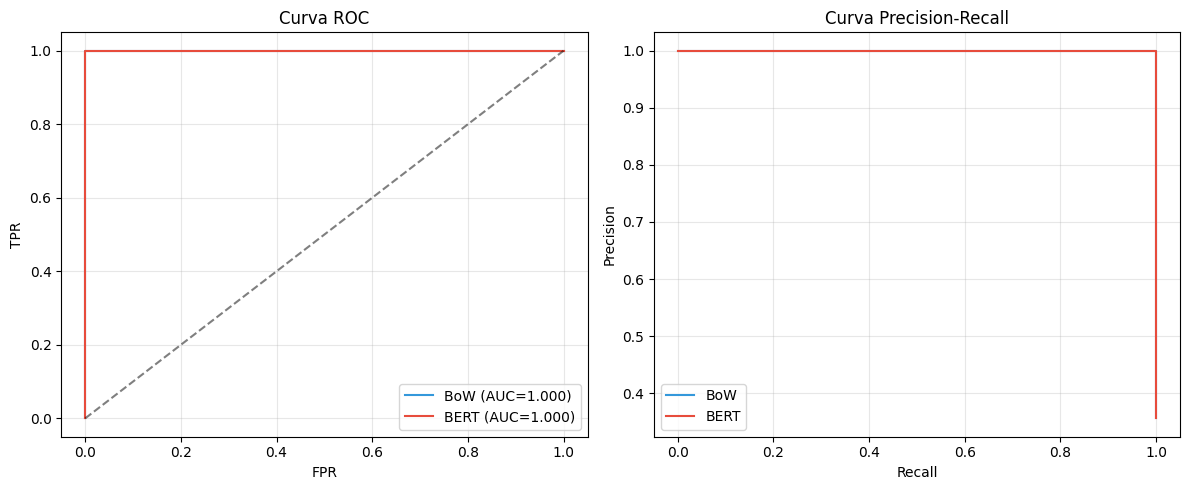

In [10]:
# Calcular curvas
fpr_bow, tpr_bow, _ = roc_curve(y_test, y_prob_bow)
fpr_bert, tpr_bert, _ = roc_curve(y_test, y_prob_bert)

prec_bow, rec_bow, _ = precision_recall_curve(y_test, y_prob_bow)
prec_bert, rec_bert, _ = precision_recall_curve(y_test, y_prob_bert)

# Graficar
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

# ROC
ax1.plot(fpr_bow, tpr_bow, label=f'BoW (AUC={auc_bow:.3f})', color='#3498db')
ax1.plot(fpr_bert, tpr_bert, label=f'BERT (AUC={auc_bert:.3f})', color='#e74c3c')
ax1.plot([0, 1], [0, 1], 'k--', alpha=0.5)
ax1.set_xlabel('FPR')
ax1.set_ylabel('TPR')
ax1.set_title('Curva ROC')
ax1.legend()
ax1.grid(alpha=0.3)

# PR
ax2.plot(rec_bow, prec_bow, label=f'BoW', color='#3498db')
ax2.plot(rec_bert, prec_bert, label=f'BERT', color='#e74c3c')
ax2.set_xlabel('Recall')
ax2.set_ylabel('Precision')
ax2.set_title('Curva Precision-Recall')
ax2.legend()
ax2.grid(alpha=0.3)

plt.tight_layout()
plt.savefig('out/curvas_roc_pr.png')
plt.show()

## 4. Comparación de métricas

In [11]:
# Memoria
process = psutil.Process()
mem_actual = process.memory_info().rss / 1024 / 1024

# Tabla comparativa
comparacion = pd.DataFrame({
    'Modelo': ['BoW + Logistic', 'DistilBERT'],
    'F1 Macro': [f1_bow, f1_bert],
    'ROC-AUC': [auc_bow, auc_bert],
    'Tiempo (s)': [np.mean(bow_times), tiempo_bert],
    'Parámetros': ['~5K features', '135M params']
})

print("\nComparación final:")
print(comparacion.to_string(index=False))

# Guardar
comparacion.to_csv('out/comparacion_modelos.csv', index=False)
print(f"\nMemoria pico: {mem_actual:.2f} MB")


Comparación final:
        Modelo  F1 Macro  ROC-AUC  Tiempo (s)   Parámetros
BoW + Logistic       1.0      1.0    0.012549 ~5K features
    DistilBERT       1.0      1.0   85.536829  135M params

Memoria pico: 505.41 MB
